In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "lambda"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.47it/s]

13it [00:00,  9.03it/s]

27it [00:00, 12.53it/s]

41it [00:00, 17.21it/s]

51it [00:00, 22.86it/s]

64it [00:00, 30.31it/s]

77it [00:00, 39.29it/s]

90it [00:00, 49.50it/s]

103it [00:00, 60.54it/s]

116it [00:01, 71.81it/s]

129it [00:01, 80.21it/s]

141it [00:01, 83.31it/s]

154it [00:01, 92.73it/s]

166it [00:01, 98.29it/s]

179it [00:01, 105.59it/s]

191it [00:01, 108.97it/s]

203it [00:01, 107.75it/s]

215it [00:01, 107.60it/s]

228it [00:02, 112.42it/s]

241it [00:02, 116.08it/s]

254it [00:02, 119.38it/s]

267it [00:02, 119.51it/s]

280it [00:02, 108.01it/s]

292it [00:02, 109.44it/s]

305it [00:02, 114.49it/s]

319it [00:02, 118.74it/s]

332it [00:02, 115.61it/s]

344it [00:03, 112.77it/s]

356it [00:03, 111.37it/s]

369it [00:03, 115.91it/s]

381it [00:03, 107.92it/s]

394it [00:03, 111.79it/s]

407it [00:03, 115.65it/s]

420it [00:03, 118.33it/s]

433it [00:03, 119.66it/s]

446it [00:03, 110.15it/s]

459it [00:04, 114.13it/s]

472it [00:04, 117.31it/s]

485it [00:04, 120.35it/s]

498it [00:04, 117.96it/s]

511it [00:04, 121.17it/s]

524it [00:04, 123.13it/s]

538it [00:04, 125.26it/s]

551it [00:04, 125.25it/s]

564it [00:04, 125.21it/s]

577it [00:05, 121.31it/s]

590it [00:05, 122.14it/s]

603it [00:05, 123.22it/s]

616it [00:05, 118.46it/s]

629it [00:05, 120.87it/s]

642it [00:05, 120.71it/s]

655it [00:05, 122.13it/s]

668it [00:05, 122.47it/s]

681it [00:05, 123.22it/s]

694it [00:05, 124.45it/s]

707it [00:06, 124.78it/s]

720it [00:06, 120.87it/s]

733it [00:06, 110.66it/s]

745it [00:06, 101.96it/s]

756it [00:06, 95.18it/s] 

767it [00:06, 97.81it/s]

779it [00:06, 102.89it/s]

793it [00:06, 109.70it/s]

806it [00:07, 114.75it/s]

819it [00:07, 117.19it/s]

831it [00:07, 104.49it/s]

842it [00:07, 98.94it/s] 

855it [00:07, 105.00it/s]

866it [00:07, 93.10it/s] 

879it [00:07, 100.97it/s]

892it [00:07, 106.75it/s]

904it [00:07, 110.09it/s]

916it [00:08, 112.80it/s]

929it [00:08, 116.11it/s]

941it [00:08, 113.97it/s]

954it [00:08, 117.71it/s]

966it [00:08, 108.07it/s]

979it [00:08, 113.08it/s]

992it [00:08, 115.66it/s]

1004it [00:08, 100.48it/s]

1015it [00:09, 98.15it/s] 

1028it [00:09, 104.86it/s]

1039it [00:09, 105.05it/s]

1052it [00:09, 110.42it/s]

1065it [00:09, 114.04it/s]

1078it [00:09, 116.72it/s]

1091it [00:09, 119.42it/s]

1104it [00:09, 116.75it/s]

1117it [00:09, 119.45it/s]

1130it [00:09, 120.86it/s]

1143it [00:10, 122.76it/s]

1156it [00:10, 123.42it/s]

1169it [00:10, 118.63it/s]

1182it [00:10, 120.58it/s]

1195it [00:10, 121.58it/s]

1208it [00:10, 121.34it/s]

1221it [00:10, 121.83it/s]

1234it [00:10, 123.04it/s]

1247it [00:10, 107.52it/s]

1259it [00:11, 110.58it/s]

1271it [00:11, 96.61it/s] 

1282it [00:11, 92.43it/s]

1292it [00:11, 88.88it/s]

1304it [00:11, 96.14it/s]

1317it [00:11, 102.54it/s]

1330it [00:11, 108.08it/s]

1342it [00:11, 103.16it/s]

1355it [00:12, 108.37it/s]

1368it [00:12, 113.93it/s]

1381it [00:12, 118.00it/s]

1394it [00:12, 121.21it/s]

1407it [00:12, 123.41it/s]

1420it [00:12, 123.52it/s]

1433it [00:12, 123.47it/s]

1439it [00:12, 113.30it/s]


0it [00:00, ?it/s]

14it [00:00, 131.84it/s]

Number of empty sat catalogs is 0


28it [00:00, 132.00it/s]

40it [00:00, 127.83it/s]

54it [00:00, 129.67it/s]

67it [00:00, 129.53it/s]

81it [00:00, 130.89it/s]

94it [00:00, 130.42it/s]

106it [00:00, 115.01it/s]

119it [00:00, 119.01it/s]

131it [00:01, 116.15it/s]

144it [00:01, 119.97it/s]

158it [00:01, 123.08it/s]

171it [00:01, 116.57it/s]

185it [00:01, 120.80it/s]

199it [00:01, 123.21it/s]

213it [00:01, 125.49it/s]

226it [00:01, 125.81it/s]

239it [00:01, 122.12it/s]

252it [00:02, 122.75it/s]

265it [00:02, 121.84it/s]

278it [00:02, 119.44it/s]

290it [00:02, 104.92it/s]

304it [00:02, 111.95it/s]

317it [00:02, 116.18it/s]

331it [00:02, 120.65it/s]

344it [00:02, 123.26it/s]

358it [00:02, 126.13it/s]

372it [00:03, 128.37it/s]

386it [00:03, 129.26it/s]

400it [00:03, 128.39it/s]

413it [00:03, 128.86it/s]

427it [00:03, 129.72it/s]

441it [00:03, 118.51it/s]

455it [00:03, 123.90it/s]

469it [00:03, 126.47it/s]

483it [00:03, 128.05it/s]

497it [00:04, 129.95it/s]

511it [00:04, 105.40it/s]

523it [00:04, 100.52it/s]

537it [00:04, 108.06it/s]

551it [00:04, 114.75it/s]

565it [00:04, 120.16it/s]

578it [00:04, 122.36it/s]

592it [00:04, 124.70it/s]

606it [00:04, 124.89it/s]

619it [00:05, 117.09it/s]

633it [00:05, 121.24it/s]

646it [00:05, 98.03it/s] 

657it [00:05, 94.63it/s]

669it [00:05, 99.43it/s]

680it [00:05, 100.43it/s]

691it [00:05, 94.36it/s] 

701it [00:05, 90.59it/s]

711it [00:06, 91.25it/s]

723it [00:06, 97.98it/s]

737it [00:06, 106.14it/s]

748it [00:06, 91.80it/s] 

758it [00:06, 91.05it/s]

771it [00:06, 99.34it/s]

783it [00:06, 102.72it/s]

797it [00:06, 111.01it/s]

811it [00:06, 116.44it/s]

825it [00:07, 121.03it/s]

839it [00:07, 124.99it/s]

853it [00:07, 127.26it/s]

867it [00:07, 129.32it/s]

881it [00:07, 130.56it/s]

895it [00:07, 114.19it/s]

907it [00:07, 103.61it/s]

918it [00:07, 99.78it/s] 

932it [00:08, 106.94it/s]

944it [00:08, 107.30it/s]

956it [00:08, 110.07it/s]

970it [00:08, 115.58it/s]

982it [00:08, 114.55it/s]

994it [00:08, 107.05it/s]

1006it [00:08, 109.87it/s]

1020it [00:08, 115.46it/s]

1034it [00:08, 121.17it/s]

1048it [00:09, 124.56it/s]

1062it [00:09, 127.41it/s]

1076it [00:09, 129.57it/s]

1090it [00:09, 130.70it/s]

1104it [00:09, 132.62it/s]

1118it [00:09, 134.33it/s]

1132it [00:09, 113.41it/s]

1144it [00:09, 90.65it/s] 

1155it [00:10, 81.67it/s]

1165it [00:10, 75.28it/s]

1174it [00:10, 70.86it/s]

1182it [00:10, 67.56it/s]

1190it [00:10, 65.54it/s]

1197it [00:10, 63.99it/s]

1204it [00:10, 65.05it/s]

1211it [00:10, 65.83it/s]

1218it [00:11, 64.26it/s]

1225it [00:11, 63.18it/s]

1232it [00:11, 62.51it/s]

1239it [00:11, 60.44it/s]

1246it [00:11, 59.93it/s]

1253it [00:11, 60.18it/s]

1260it [00:11, 57.87it/s]

1273it [00:11, 69.37it/s]

1287it [00:11, 81.14it/s]

1301it [00:12, 92.00it/s]

1314it [00:12, 100.83it/s]

1328it [00:12, 108.33it/s]

1342it [00:12, 115.17it/s]

1355it [00:12, 119.02it/s]

1369it [00:12, 122.63it/s]

1383it [00:12, 126.02it/s]

1397it [00:12, 128.25it/s]

1411it [00:13, 100.16it/s]

1423it [00:13, 103.00it/s]

1437it [00:13, 110.16it/s]

1439it [00:13, 108.48it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

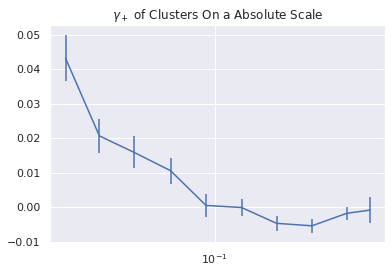

Aggregated xi:
[-10.1837 -11.2231 -13.1248 -14.1796  -1.1451   0.2116  23.7168  36.2858
  12.041    1.1937]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1018.5574 -2095.5961 -2796.4155 -3877.2421 -5189.2937 -6755.0864
 -7500.6041 -6694.2877 -3575.7728  -303.4928]
------------------------------------------------------------------------------
Aggregated npairs:
[ 236.  543.  824. 1338. 2145. 3483. 5115. 6766. 6869. 1473.]
------------------------------------------------------------------------------
Mean xi:
[-4.3151e-02 -2.0669e-02 -1.5928e-02 -1.0598e-02 -5.3386e-04  6.0765e-05
  4.6367e-03  5.3630e-03  1.7530e-03  8.1042e-04]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3159 -3.8593 -3.3937 -2.8978 -2.4193 -1.9394 -1.4664 -0.9894 -0.5206
 -0.206 ]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

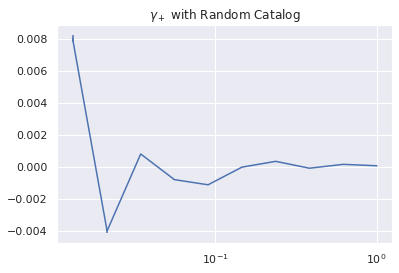

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1251e-04  1.0589e-04 -2.1349e-05  2.1090e-05  2.9613e-05  4.4588e-07
 -9.1304e-06  2.2014e-06 -4.1878e-06 -1.8368e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

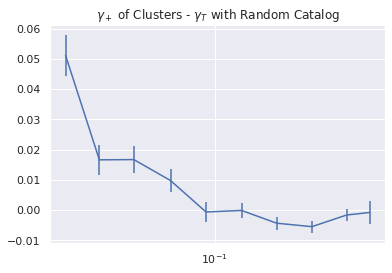

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

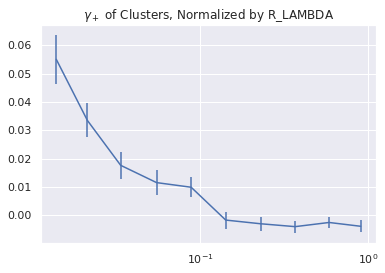

Aggregated xi:
[ -6.1648 -11.7597 -12.1848 -11.3814 -15.9619   4.4288  12.3434  23.0544
  17.594   21.0375]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -479.7472 -1353.548  -2345.1914 -2861.6877 -3909.9352 -5204.2516
 -6142.1897 -5799.8308 -3745.1494  -550.4611]
------------------------------------------------------------------------------
Aggregated npairs:
[ 112.  351.  690.  985. 1609. 2662. 4163. 5792. 7004. 5461.]
------------------------------------------------------------------------------
Mean xi:
[-0.055  -0.0335 -0.0177 -0.0116 -0.0099  0.0017  0.003   0.004   0.0025
  0.0039]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2835 -3.8563 -3.3988 -2.9053 -2.43   -1.955  -1.4754 -1.0014 -0.5347
 -0.1008]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)